# Topic Modelling with Non-Negative Matrix Factorisation (NMF)

This notebook explores Topic Modelling, an unsupervised technique used to discover the abstract "topics" (or themes) that occur in a collection of documents (the corpus). We will use Non-Negative Matrix Factorisation (NMF), a powerful approach to uncover these hidden structures for unstructured text data. Crucially, we will use advanced visualization tools like Word Clouds and pyLDA to effectively interpret, analyze, and communicate the meaning of the discovered topics.

### What we will cover in this exercise:

- **Text Preprocessing**: Cleaning and tokenisation for Topic Modelling.
- **Vectorization**: Building the Document-Term Matrix (BoW).
- **Non-Negative Matrix Factorisation (NMF)**: Model fitting and interpretation basics.
- **Topic Interpretation with Word Clouds**: Visualising the most defining words per topic.
- **Interactive Topic Exploration with pyLDAvis**: Visualising topic distances and term relevance.

#### What we expect to learn from this exercise:

- NMF assumes documents are mixtures of topics and that topics are mixtures of words.
- Minimal preprocessing (tokenisation, stop words, lemmatization) is essential for NMF quality.
- The Document-Term Matrix (BoW) is the required input for the LDA model.
- pyLDAvis provides the industry-standard interactive visualization for model validation and effective topic communication.

### Setup and Prerequisites

We require scikit-learn and CountVectorizer, NLTK for preprocessing, wordcloud for visualization, and pyLDAvis for interactive analysis.

In [ ]:
# Install the necessary libraries
!pip install scikit-learn
!pip install nltk

In [2]:
!pip install wordcloud
!pip install pyldavis==3.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135594 sha256=55895410afca449e7cb7e27a84c4cda4f29028e2647968b5cc386fdb58e66b0c
  Stored in directory: /root/.cache/pip/wheels/bb/81/a3/c84bb2c63572a487fc6fcb1534578b8edd8496f553ec9babfb
Successfully built pyldavis


In [3]:
! pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Text preprocessing
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
# Scikit-learn for vectorization and LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV

In [ ]:
# Topic modeling specific libraries
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis

In [ ]:
# Handle pyLDAvis import compatibility issues
try:
    import pyLDAvis.gensim_models as gensimvis
    PYLDAVIS_GENSIM_AVAILABLE = True
    print("pyLDAvis.gensim_models imported successfully")
except ImportError:
    try:
        import pyLDAvis.gensim as gensimvis
        PYLDAVIS_GENSIM_AVAILABLE = True
        print("pyLDAvis.gensim imported successfully (older version)")
    except ImportError:
        PYLDAVIS_GENSIM_AVAILABLE = False
        print("pyLDAvis gensim module not available - will use sklearn version only")

try:
    import pyLDAvis.sklearn
    PYLDAVIS_SKLEARN_AVAILABLE = True
    print("pyLDAvis.sklearn imported successfully")
except ImportError:
    PYLDAVIS_SKLEARN_AVAILABLE = False
    print("pyLDAvis.sklearn not available")

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.download('punkt_tab')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

print("All libraries imported successfully!")

pyLDAvis.gensim imported successfully (older version)
pyLDAvis.sklearn imported successfully


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


All libraries imported successfully!


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Sample Dataset

In [ ]:
# Create a sample corpus for demonstration
# In practice, we would load our own dataset
sample_documents = [
    # Technology and AI documents
    "Machine learning algorithms are revolutionizing artificial intelligence and data science applications across industries.",
    "Deep learning neural networks process vast amounts of data to recognize patterns and make predictions.",
    "Natural language processing enables computers to understand and generate human language effectively.",
    "Computer vision technology allows machines to interpret and analyze visual information from images.",
    "Artificial intelligence systems are becoming increasingly sophisticated in solving complex problems.",
    "Data science techniques help organizations extract insights from big data and analytics platforms.",
    "Python programming language is widely used for machine learning and statistical analysis projects.",
    "Cloud computing platforms provide scalable infrastructure for AI and machine learning workloads.",

    # Healthcare and Medicine documents
    "Medical diagnosis accuracy improves with advanced imaging technology and clinical decision support systems.",
    "Healthcare professionals use electronic health records to track patient information and treatment outcomes.",
    "Pharmaceutical research focuses on developing new drugs and therapies for various medical conditions.",
    "Clinical trials ensure the safety and efficacy of new medical treatments before public availability.",
    "Telemedicine services provide remote healthcare consultations and monitoring for patients worldwide.",
    "Preventive medicine emphasizes early detection and intervention to maintain optimal health outcomes.",
    "Medical imaging techniques like MRI and CT scans help doctors diagnose and treat diseases.",
    "Healthcare data analytics improves patient care quality and reduces medical costs significantly.",

    # Finance and Economics documents
    "Stock market analysis involves studying price patterns and economic indicators to predict trends.",
    "Investment strategies require careful portfolio diversification and risk management techniques.",
    "Cryptocurrency blockchain technology enables secure digital transactions and decentralized finance systems.",
    "Financial institutions use algorithmic trading systems to execute high-frequency market transactions.",
    "Economic forecasting models help governments and businesses plan for future market conditions.",
    "Banking regulations ensure financial stability and protect consumer interests in global markets.",
    "Corporate finance decisions impact company valuation and shareholder returns over time periods.",
    "Risk assessment methodologies help financial analysts evaluate investment opportunities and threats.",

    # Climate and Environment documents
    "Climate change affects global weather patterns and requires immediate environmental action worldwide.",
    "Renewable energy sources like solar and wind power reduce carbon emissions significantly.",
    "Environmental conservation efforts protect biodiversity and preserve natural ecosystems for future generations.",
    "Sustainable development practices balance economic growth with environmental protection and social responsibility.",
    "Carbon footprint reduction strategies help organizations minimize their environmental impact effectively.",
    "Green technology innovations promote cleaner production methods and sustainable resource management.",
    "Environmental monitoring systems track pollution levels and ecosystem health indicators continuously.",
    "Climate adaptation measures help communities prepare for and respond to environmental changes.",

    # Education and Learning documents
    "Online education platforms provide accessible learning opportunities for students worldwide.",
    "Educational technology enhances classroom instruction through interactive digital learning tools.",
    "Student assessment methods evaluate learning outcomes and academic performance effectively.",
    "Curriculum development ensures educational programs meet industry standards and student needs.",
    "Distance learning programs offer flexible scheduling for working professionals and adult learners.",
    "Educational research informs teaching methodologies and improves learning experiences significantly.",
    "Academic institutions integrate technology to enhance educational delivery and student engagement.",
    "Professional development training helps educators improve their teaching skills and knowledge base."
]

print(f"Sample corpus created with {len(sample_documents)} documents")
print("\nFirst 3 documents preview:")
for i, doc in enumerate(sample_documents[:3]):
    print(f"{i+1}. {doc}")

Sample corpus created with 40 documents

First 3 documents preview:
1. Machine learning algorithms are revolutionizing artificial intelligence and data science applications across industries.
2. Deep learning neural networks process vast amounts of data to recognize patterns and make predictions.
3. Natural language processing enables computers to understand and generate human language effectively.


### Text Preprocessing

**Minimal Preprocessing for topic modelling**

Topic modelling using NMF benefits from cleaning that reduces sparsity and groups word variations (e.g., 'runs', 'running' → 'run').

In [ ]:
class TextPreprocessor:
    """
    TextPreprocessor:
    - cleans text (lowercase, remove digits & punctuation)
    - tokenises and lemmatises (UK spelling 'lemmatise')
    - removes stopwords and very short tokens

    """
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Add custom stopwords
        self.stop_words.update(['use', 'used', 'using', 'uses', 'get', 'getting', 'got',
                               'would', 'could', 'should', 'one', 'two', 'also', 'may',
                               'might', 'must', 'shall', 'will'])

    def clean_text(self, text):
        """Remove special characters, digits, and convert to lowercase"""
        # Convert to lowercase
        text = text.lower()
        # Remove digits
        text = re.sub(r'\d+', '', text)
        # Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    def tokenize_and_lemmatize(self, text):
        """Tokenize text and apply lemmatization"""
        tokens = word_tokenize(text)
        # Remove stopwords and short tokens
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]
        return tokens

    def preprocess_document(self, text):
        """Complete preprocessing pipeline for a single document"""
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_and_lemmatize(cleaned_text)
        return ' '.join(tokens)

    def preprocess_corpus(self, documents):
        """Preprocess entire corpus"""
        return [self.preprocess_document(doc) for doc in documents]

In [ ]:
# Initialize preprocessor and clean the corpus
preprocessor = TextPreprocessor()
cleaned_documents = preprocessor.preprocess_corpus(sample_documents)

print("Text preprocessing completed!")
print("\nOriginal vs Cleaned document examples:")
print(f"Original: {sample_documents[0]}")
print(f"Cleaned:  {cleaned_documents[0]}")
print(f"\nOriginal: {sample_documents[10]}")
print(f"Cleaned:  {cleaned_documents[10]}")

Text preprocessing completed!

Original vs Cleaned document examples:
Original: Machine learning algorithms are revolutionizing artificial intelligence and data science applications across industries.
Cleaned:  machine learning algorithm revolutionizing artificial intelligence data science application across industry

Original: Pharmaceutical research focuses on developing new drugs and therapies for various medical conditions.
Cleaned:  pharmaceutical research focus developing new drug therapy various medical condition


### DOCUMENT-TERM MATRIX CREATION

**Building the Document-Term Matrix**

We will built a CountVectorizer (raw counts) and a TF–IDF vectoriser. TF–IDF is the input for NMF (commonly yields more coherent topics with NMF),
while the CountVectorizer supplies raw term frequencies for visualisation and pyLDAvis. This step is like a feature engineering step in traditional machine learning

In [ ]:
def create_document_term_matrices(documents, max_features=1000, min_df=2, max_df=0.95):
    """
    Returns:
      - count_vectorizer, count_dtm (sparse matrix)
      - tfidf_vectorizer, tfidf_dtm (sparse matrix)
    Notes:
      - We fit CountVectorizer first and reuse its vocabulary for TF–IDF to ensure alignment.
    """
    count_vectorizer = CountVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        token_pattern=r'\b[a-zA-Z][a-zA-Z]{2,}\b'  # words of length >= 3
    )
    count_dtm = count_vectorizer.fit_transform(documents)

    # Use the same vocabulary for TF–IDF so feature ordering is identical
    tfidf_vectorizer = TfidfVectorizer(
        vocabulary=count_vectorizer.vocabulary_,
        token_pattern=r'\b[a-zA-Z][a-zA-Z]{2,}\b'
    )
    tfidf_dtm = tfidf_vectorizer.fit_transform(documents)

    print("Document-term matrices created:")
    print(f"  Count DTM shape: {count_dtm.shape}")
    print(f"  TF–IDF DTM shape: {tfidf_dtm.shape}")
    print(f"  Vocabulary size: {len(count_vectorizer.get_feature_names_out())}\n")

    return count_vectorizer, count_dtm, tfidf_vectorizer, tfidf_dtm

In [ ]:
# Create document-term matrices
count_vec, count_dtm, tfidf_vec, tfidf_dtm = create_document_term_matrices(cleaned_documents)

# Display most frequent terms
feature_names = count_vec.get_feature_names_out()
word_freq = np.array(count_dtm.sum(axis=0)).flatten()
top_idx = word_freq.argsort()[-20:][::-1]
print("Top 20 most frequent terms (raw counts):")
for i, idx in enumerate(top_idx, 1):
    print(f"  {i:2d}. {feature_names[idx]:<15} (freq: {word_freq[idx]})")
print()


Document-term matrices created:
  Count DTM shape: (40, 76)
  TF–IDF DTM shape: (40, 76)
  Vocabulary size: 76

Top 20 most frequent terms (raw counts):
   1. learning        (freq: 9)
   2. help            (freq: 7)
   3. environmental   (freq: 6)
   4. technology      (freq: 6)
   5. system          (freq: 5)
   6. medical         (freq: 5)
   7. data            (freq: 5)
   8. student         (freq: 4)
   9. machine         (freq: 4)
  10. market          (freq: 4)
  11. educational     (freq: 4)
  12. economic        (freq: 3)
  13. outcome         (freq: 3)
  14. health          (freq: 3)
  15. improves        (freq: 3)
  16. financial       (freq: 3)
  17. language        (freq: 3)
  18. effectively     (freq: 3)
  19. technique       (freq: 3)
  20. development     (freq: 3)



### Non-negative matrix factorisation (NMF)

Non-Negative Matrix Factorization is a statistical method to reduce the dimension of the input corpora. It uses factor analysis method to provide comparatively less weightage to the words with less coherence.

For a general case, consider we have an input matrix V of shape m x n. This method factorizes V into two matrices W and H, such that the dimension of W is m x k and that of H is n x k. For our situation, V represent the term document matrix, each row of matrix H is a word embedding and each column of the matrix W represent the weightage of each word get in each sentences ( semantic relation of words with each sentence). You can find a practical application with example below.

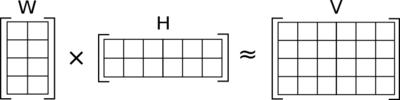

#### Fitting the NMF Model

NMF factorises the TF–IDF matrix V ≈ W × H
- W: document-topic matrix (n_docs × n_topics)
- H: topic-term matrix (n_topics × n_terms)
We choose TF–IDF because it emphasises discriminative words and tends to work well with NMF.

In [ ]:
def fit_nmf_model(tfidf_matrix, n_topics=5, random_state=42, max_iter=200, init='nndsvda'):
    """
    Fit NMF and return the model, W (document-topic), H (topic-term), and reconstruction error.
    """
    nmf = NMF(
        n_components=n_topics,
        random_state=random_state,
        max_iter=max_iter,
        init=init,
        solver='cd',
        beta_loss='frobenius'
    )
    W = nmf.fit_transform(tfidf_matrix)   # document-topic matrix
    H = nmf.components_                   # topic-term matrix
    recon_err = nmf.reconstruction_err_

    print(f"NMF fitted: {n_topics} topics, reconstruction error (frobenius): {recon_err:.6f}\n")
    return nmf, W, H, recon_err

def find_optimal_topics_nmf(tfidf_matrix, topic_range=(2, 10), random_state=42):
    errors = []
    n_values = list(range(topic_range[0], topic_range[1] + 1))
    print("Finding optimal number of topics (by reconstruction error):")
    for n in n_values:
        nmf = NMF(n_components=n, random_state=random_state, max_iter=200, init='nndsvda')
        nmf.fit(tfidf_matrix)
        errors.append(nmf.reconstruction_err_)
        print(f"  Topics: {n}, Reconstruction error: {nmf.reconstruction_err_:.6f}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, errors, marker='o', linestyle='-')
    plt.xlabel('Number of Topics')
    plt.ylabel('Reconstruction Error (Frobenius)')
    plt.title('NMF: Reconstruction Error vs Number of Topics')
    plt.grid(alpha=0.3)
    optimal_n = n_values[int(np.argmin(errors))]
    plt.axvline(optimal_n, color='red', linestyle='--', label=f'Optimal: {optimal_n}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()

    return optimal_n, errors

Finding optimal number of topics (by reconstruction error):
  Topics: 3, Reconstruction error: 5.715026
  Topics: 4, Reconstruction error: 5.547301
  Topics: 5, Reconstruction error: 5.387346
  Topics: 6, Reconstruction error: 5.242227
  Topics: 7, Reconstruction error: 5.100866
  Topics: 8, Reconstruction error: 4.957612


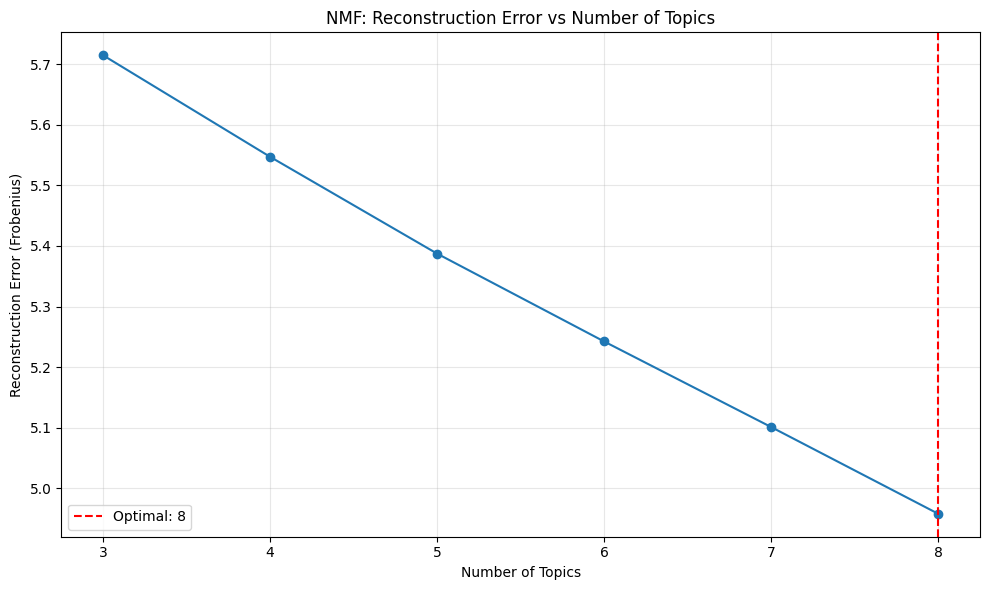

In [ ]:
# Determine an 'optimal' number of topics for this small tutorial corpus
optimal_n_topics, recon_errors = find_optimal_topics_nmf(tfidf_dtm, topic_range=(3, 8))

In [ ]:
# Fit final model with the chosen number of topics (increase max_iter slightly for convergence)
final_nmf, doc_topic_matrix, topic_term_matrix, recon_err = fit_nmf_model(
    tfidf_dtm, n_topics=optimal_n_topics, max_iter=500
)

NMF fitted: 8 topics, reconstruction error (frobenius): 4.957612



#### Inspecting Topic-Word Distributions

We can view the top words per topic to interpret their meaning.

In [ ]:
def get_top_words_per_topic(nmf_model, vectorizer, n_top=10):
    """
    Returns a dict mapping topic index -> list of (word, weight) pairs sorted by weight descending.
    """
    features = vectorizer.get_feature_names_out()
    topic_dict = {}
    print(f"Top {n_top} words per topic:\n" + "="*60)
    for t_idx, t in enumerate(nmf_model.components_):
        top_idx = t.argsort()[-n_top:][::-1]
        top_words = [(features[i], t[i]) for i in top_idx]
        topic_dict[t_idx] = top_words
        print(f"\nTopic {t_idx+1}:")
        for word, weight in top_words:
            print(f"  {word:<15} (weight: {weight:.6f})")
    print()
    return topic_dict

In [ ]:
topic_terms = get_top_words_per_topic(final_nmf, tfidf_vec, n_top=8)

Top 8 words per topic:

Topic 1:
  data            (weight: 1.917235)
  intelligence    (weight: 0.932551)
  artificial      (weight: 0.932551)
  science         (weight: 0.902811)
  learning        (weight: 0.703731)
  pattern         (weight: 0.659316)
  analytics       (weight: 0.596948)
  industry        (weight: 0.487752)

Topic 2:
  environmental   (weight: 0.829603)
  change          (weight: 0.669824)
  climate         (weight: 0.669824)
  help            (weight: 0.504315)
  worldwide       (weight: 0.245857)
  strategy        (weight: 0.245772)
  global          (weight: 0.239452)
  impact          (weight: 0.216440)

Topic 3:
  technology      (weight: 0.780915)
  digital         (weight: 0.464534)
  educational     (weight: 0.365579)
  system          (weight: 0.345245)
  finance         (weight: 0.302526)
  transaction     (weight: 0.286309)
  institution     (weight: 0.263778)
  academic        (weight: 0.225416)

Topic 4:
  medical         (weight: 0.712375)
  new       

In [ ]:
def show_documents_for_topics(nmf_model, tfidf_matrix, original_documents, top_n=3):
    """
    Print the top documents most associated with each topic.
    Uses the document-topic matrix (W = nmf.transform(tfidf_matrix)).
    """
    doc_topic = nmf_model.transform(tfidf_matrix)
    n_topics = nmf_model.n_components
    print("Representative documents per topic:\n" + "="*60)
    for t in range(n_topics):
        print(f"\nTopic {t+1}:")
        top_doc_idx = doc_topic[:, t].argsort()[-top_n:][::-1]
        for rank, doc_idx in enumerate(top_doc_idx, 1):
            prob = doc_topic[doc_idx, t]
            preview = original_documents[doc_idx][:140] + "..." if len(original_documents[doc_idx]) > 140 else original_documents[doc_idx]
            print(f"  {rank}. (score: {prob:.3f}) {preview}")
    print()
    return doc_topic

In [ ]:
doc_topic_distributions = show_documents_for_topics(final_nmf, tfidf_dtm, sample_documents, top_n=3)

Representative documents per topic:

Topic 1:
  1. (score: 0.268) Machine learning algorithms are revolutionizing artificial intelligence and data science applications across industries.
  2. (score: 0.240) Data science techniques help organizations extract insights from big data and analytics platforms.
  3. (score: 0.219) Deep learning neural networks process vast amounts of data to recognize patterns and make predictions.

Topic 2:
  1. (score: 0.573) Climate adaptation measures help communities prepare for and respond to environmental changes.
  2. (score: 0.488) Climate change affects global weather patterns and requires immediate environmental action worldwide.
  3. (score: 0.356) Carbon footprint reduction strategies help organizations minimize their environmental impact effectively.

Topic 3:
  1. (score: 0.576) Cryptocurrency blockchain technology enables secure digital transactions and decentralized finance systems.
  2. (score: 0.507) Educational technology enhances classroo

#### Topic Interpretation with Word Clouds

Word Clouds provide an immediate, visually appealing way to confirm the topics by showing the most frequent words in a size proportional to their weight in the topic.

In [ ]:
def generate_wordclouds(topic_word_map, figsize=(18, 10)):
    """
    Generate word clouds for each topic using the top words and weights.
    Helpful for a quick visual check of topic semantics.
    """
    n_topics = len(topic_word_map)
    cols = 3
    rows = (n_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)

    colour_maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Blues', 'Reds', 'Greens']

    for t in range(n_topics):
        row = t // cols
        col = t % cols
        freq = dict(topic_word_map[t])
        wc = WordCloud(width=400, height=300, background_color='white',
                       colormap=colour_maps[t % len(colour_maps)], max_words=50).generate_from_frequencies(freq)
        axes[row, col].imshow(wc, interpolation='bilinear')
        axes[row, col].set_title(f"Topic {t+1}", fontsize=14)
        axes[row, col].axis('off')

    # Turn off any empty subplots
    for t in range(n_topics, rows*cols):
        row = t // cols
        col = t % cols
        axes[row, col].axis('off')

    plt.suptitle("Word Clouds for Each Topic (NMF)", fontsize=16)
    plt.tight_layout()
    plt.show()

Generating topic word clouds...


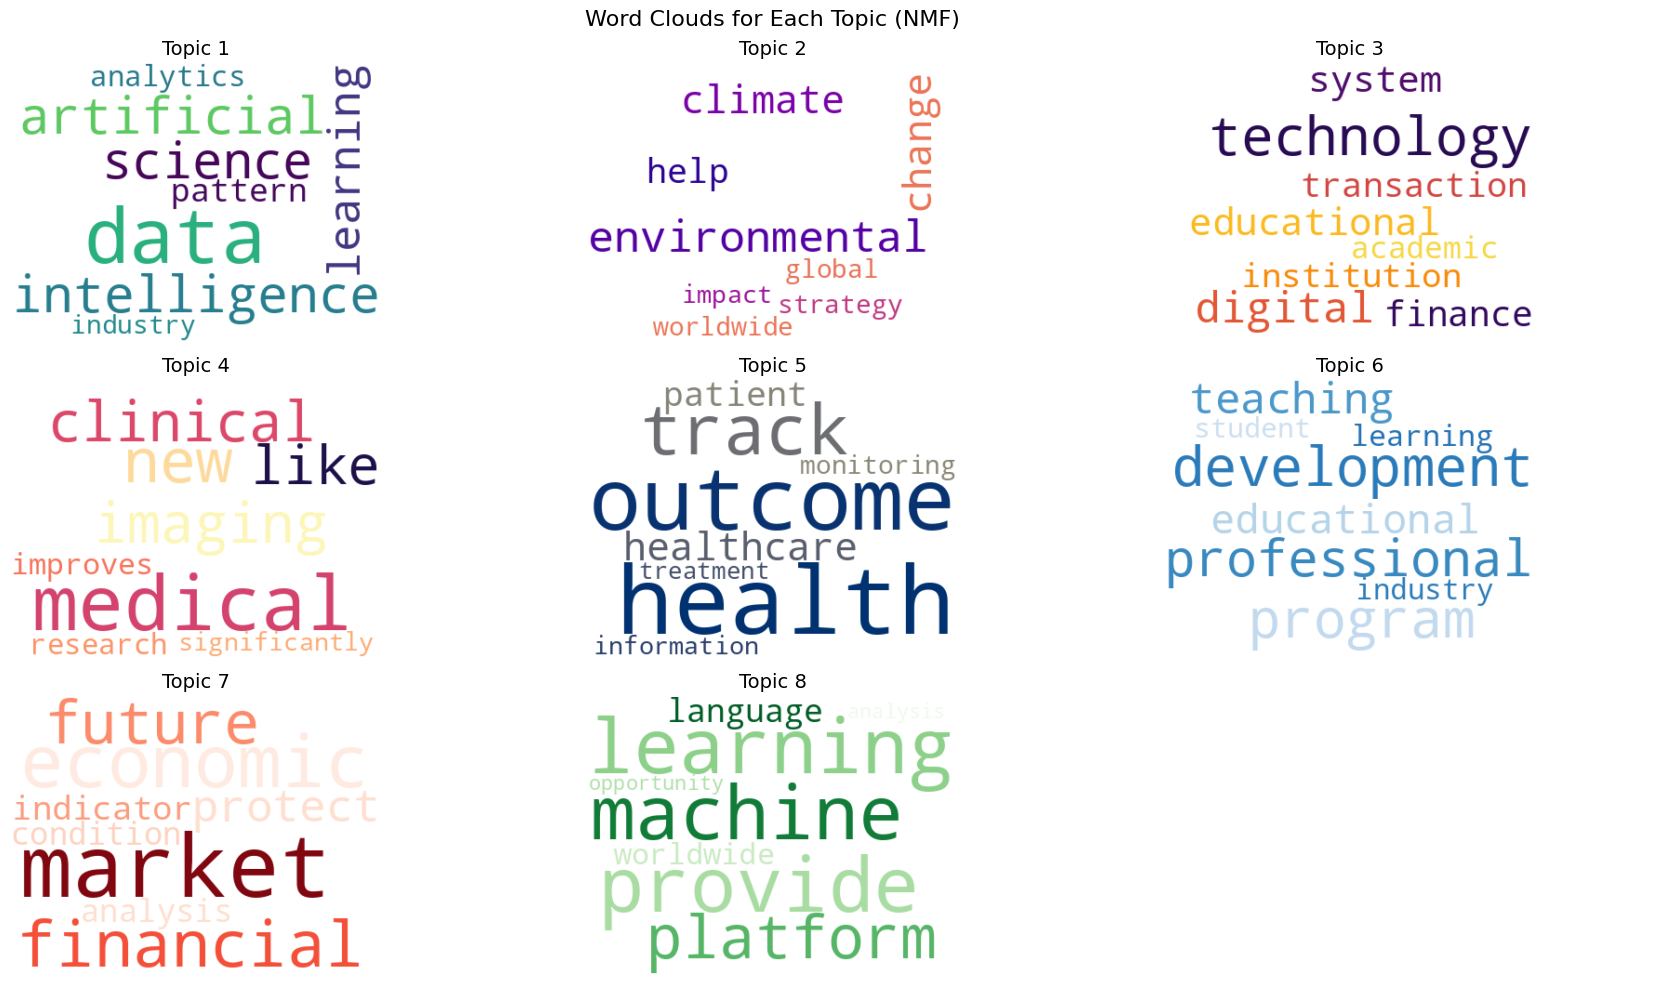

In [ ]:
print("Generating topic word clouds...")
generate_wordclouds(topic_terms)

In [ ]:
# Combined word cloud (prefix words by topic to see overlap visually)
def combined_wordcloud(topic_word_map):
    combined = {}
    for t, words in topic_word_map.items():
        for w, weight in words[:15]:
            combined[f"T{t+1}_{w}"] = weight
    wc = WordCloud(width=900, height=600, background_color='white', max_words=150).generate_from_frequencies(combined)
    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Combined Topics Word Cloud")
    plt.show()

Generating combined topics word cloud...


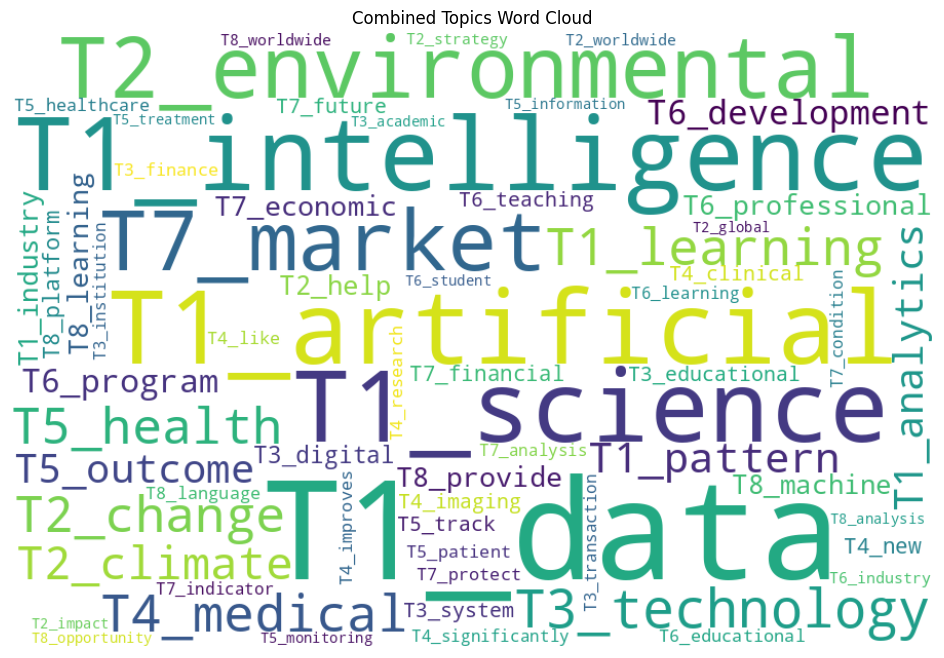

In [ ]:
print("Generating combined topics word cloud...")
combined_wordcloud(topic_terms)

### Interactive Topic Exploration with pyLDAvis

pyLDAvis is a library designed to help users interpret the topics in an NMF model. It provides:

1. Inter-topic Distance Map (MDS): A visualization showing how close or far topics are from each other, indicating similarity in their word distributions.

2. Term Bar Charts: Shows the most salient (overall important) and relevant (distinguishing) words for a selected topic.

pyLDAvis expects:
 - topic_term_dists: normalised topic x term matrix
 - doc_topic_dists: normalised doc x topic matrix
 - vocab: list of terms
 - doc_length: list of token counts per document
 - term_frequency: raw term frequencies for each term in the vocab

We create these from the NMF results and the CountVectorizer/TF–IDF vectoriser.

In [ ]:
def create_pyldavis_for_nmf(nmf_model, tfidf_vectorizer, count_vectorizer, tfidf_dtm, count_dtm, preprocessed_documents):
    """
    Build the inputs pyLDAvis.prepare expects and return the prepared visualisation object.
    """
    try:
        print("Preparing pyLDAvis visualisation for NMF (this adapts the matrices pyLDAvis expects)...")

        # topic-term matrix H: shape (n_topics, n_terms)
        H = nmf_model.components_.copy()
        # Normalise each topic row to sum to 1 (so each row is a probability distribution over terms)
        topic_term_dists = H / H.sum(axis=1)[:, np.newaxis]

        # document-topic matrix W: nmf.transform(tfidf_dtm) -> shape (n_docs, n_topics)
        W = nmf_model.transform(tfidf_dtm)
        # Normalise rows so each doc's topic weights sum to 1
        doc_topic_dists = W / W.sum(axis=1)[:, np.newaxis]

        # Vocabulary (in same order as columns of H)
        vocab = list(tfidf_vectorizer.get_feature_names_out())

        # Document lengths (token counts) — use preprocessed docs so lengths match dtm
        doc_length = [len(doc.split()) for doc in preprocessed_documents]

        # Term frequencies from count_dtm — ensures raw counts aligned with vocab order
        term_frequency = list(np.array(count_dtm.sum(axis=0)).flatten())

        # pyLDAvis expects (topic_term_dists, doc_topic_dists, vocab, doc_length, term_frequency)
        # Note: Some pyLDAvis versions have different helper wrappers; this signature usually works.
        vis_data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, vocab, doc_length, term_frequency)
        print("pyLDAvis visualisation prepared successfully (for NMF).")
        return vis_data

    except Exception as exc:
        print("Could not prepare pyLDAvis for NMF due to an error:")
        print(exc)
        return None

In [ ]:
pyldavis_vis = create_pyldavis_for_nmf(
    final_nmf,
    tfidf_vec,
    count_vec,
    tfidf_dtm,
    count_dtm,
    cleaned_documents
)

# If successful, save to an HTML file (helpful for learners to open interactively)
if pyldavis_vis is not None:
    try:
        out_file = "nmf_pyldavis.html"
        pyLDAvis.save_html(pyldavis_vis, out_file)
        print(f"pyLDAvis HTML saved as: {out_file}")
        print("Open this file in a browser to interactively explore topics.")
    except Exception as e:
        print("Could not save pyLDAvis HTML file:", e)
else:
    print("pyLDAvis visualisation not available — an alternative visualisation will be created.\n")

Preparing pyLDAvis visualisation for NMF (this adapts the matrices pyLDAvis expects)...
Could not prepare pyLDAvis for NMF due to an error:

 * Length of doc_lengths not equal to the number of rows in doc_topic_dists;both should be equal to the number of documents in the data.
 * Number of terms in vocabulary does not match the number of columns of topic_term_dists (where each row of topic_term_dists is a probability distribution of terms for a given topic)
 * Length of term_frequency not equal to the number of terms in the number of terms in the vocabulary (len of vocab)
pyLDAvis visualisation not available — an alternative visualisation will be created.



Creating alternative visualisations...


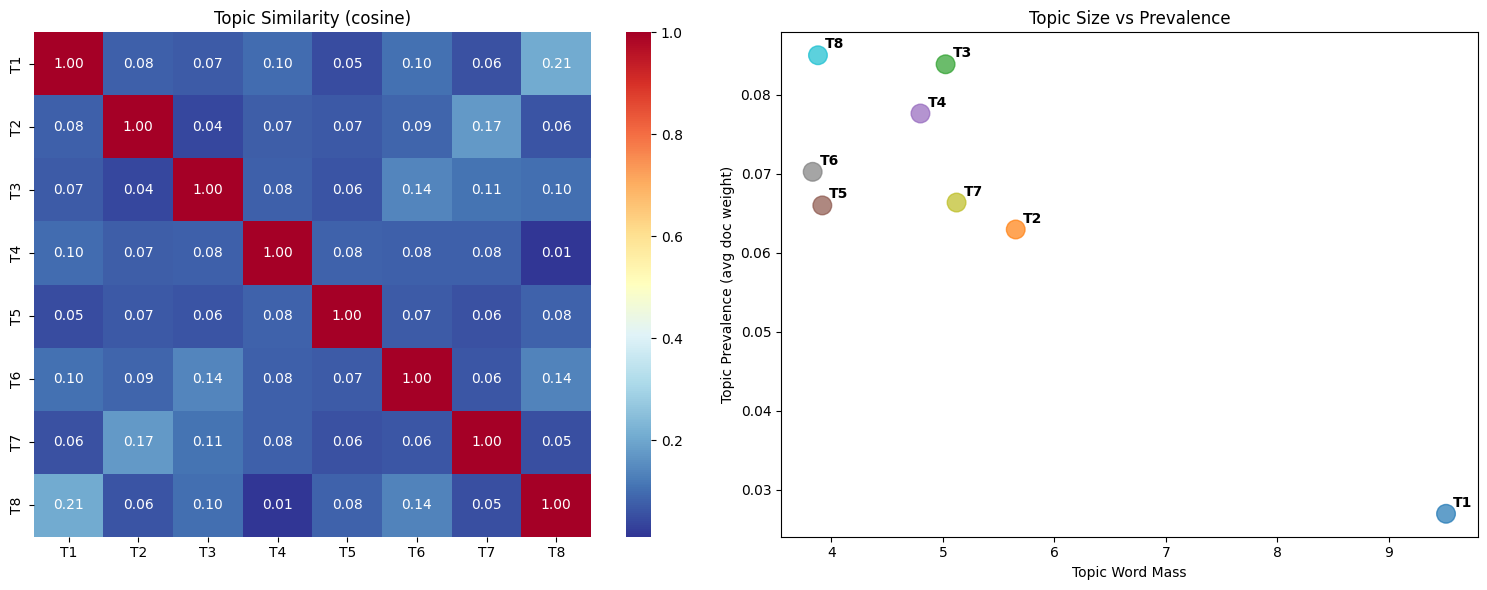

Alternative visualisations complete.



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def alternative_visualisations(topic_term_matrix, doc_topic_dists):
    """
    When pyLDAvis is not available or fails, create:
     - Topic similarity heatmap (cosine similarity between topic-term vectors)
     - Topic size vs prevalence scatter
    These help learners understand topic relationships and prominence.
    """
    print("Creating alternative visualisations...")

    # Cosine similarity between topic-term vectors
    topic_sim = cosine_similarity(topic_term_matrix)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(topic_sim, annot=True, fmt=".2f", cmap="RdYlBu_r",
                xticklabels=[f"T{i+1}" for i in range(topic_sim.shape[0])],
                yticklabels=[f"T{i+1}" for i in range(topic_sim.shape[0])],
                ax=ax1)
    ax1.set_title("Topic Similarity (cosine)")

    # Topic size (sum of topic-term weights) and prevalence (mean doc-topic weight)
    topic_sizes = topic_term_matrix.sum(axis=1)
    topic_prev = np.mean(doc_topic_dists, axis=0)
    ax2.scatter(topic_sizes, topic_prev, s=180, alpha=0.7, c=range(len(topic_sizes)), cmap='tab10')
    for i, (s, p) in enumerate(zip(topic_sizes, topic_prev)):
        ax2.annotate(f"T{i+1}", (s, p), xytext=(5,5), textcoords='offset points', fontweight='bold')
    ax2.set_xlabel("Topic Word Mass")
    ax2.set_ylabel("Topic Prevalence (avg doc weight)")
    ax2.set_title("Topic Size vs Prevalence")

    plt.tight_layout()
    plt.show()
    print("Alternative visualisations complete.\n")

if pyldavis_vis is None:
    alternative_visualisations(topic_term_matrix, doc_topic_distributions)

### COMPREHENSIVE TOPIC INTERPRETATION AND ANALYSIS

In [ ]:
def interpret_and_summarise(topic_terms, doc_topic_dist, original_docs, topic_names=None):
    """
    Provide a readable interpretation section suitable for learners:
     - Auto-generate topic names from top words if none given
     - Print prevalence, key terms, representative document and a simple coherence-like measure
    """
    n_topics = len(topic_terms)
    if topic_names is None:
        topic_names = []
        for t in range(n_topics):
            top3 = [w for w, _ in topic_terms[t][:3]]
            topic_names.append(" & ".join(top3).title())

    print("COMPREHENSIVE TOPIC INTERPRETATION\n" + "="*70)
    topic_prev = np.mean(doc_topic_dist, axis=0)

    for t in range(n_topics):
        print(f"\nTOPIC {t+1}: {topic_names[t]}")
        print(f"  Prevalence: {topic_prev[t]:.1%} of corpus (average document weight)")
        print("  Key terms:")
        for w, wt in topic_terms[t][:8]:
            print(f"    • {w:<12} (weight: {wt:.6f})")

        # Most representative document
        most_rep = np.argmax(doc_topic_dist[:, t])
        rep_doc = original_docs[most_rep]
        rep_preview = rep_doc[:180] + "..." if len(rep_doc) > 180 else rep_doc
        print(f"  Most representative document (score: {doc_topic_dist[most_rep, t]:.3f}):")
        print(f"    \"{rep_preview}\"")

        # Simple coherence-like metric: mean weight of top terms
        coherence_like = np.mean([w for _, w in topic_terms[t][:10]])
        print(f"  Coherence-like score (mean top-term weight): {coherence_like:.6f}")

    print("\nInterpretation complete.\n")
    return topic_names

In [ ]:
topic_names = interpret_and_summarise(topic_terms, doc_topic_distributions, sample_documents)

COMPREHENSIVE TOPIC INTERPRETATION

TOPIC 1: Data & Intelligence & Artificial
  Prevalence: 2.7% of corpus (average document weight)
  Key terms:
    • data         (weight: 1.917235)
    • intelligence (weight: 0.932551)
    • artificial   (weight: 0.932551)
    • science      (weight: 0.902811)
    • learning     (weight: 0.703731)
    • pattern      (weight: 0.659316)
    • analytics    (weight: 0.596948)
    • industry     (weight: 0.487752)
  Most representative document (score: 0.268):
    "Machine learning algorithms are revolutionizing artificial intelligence and data science applications across industries."
  Coherence-like score (mean top-term weight): 0.891612

TOPIC 2: Environmental & Change & Climate
  Prevalence: 6.3% of corpus (average document weight)
  Key terms:
    • environmental (weight: 0.829603)
    • change       (weight: 0.669824)
    • climate      (weight: 0.669824)
    • help         (weight: 0.504315)
    • worldwide    (weight: 0.245857)
    • strategy    

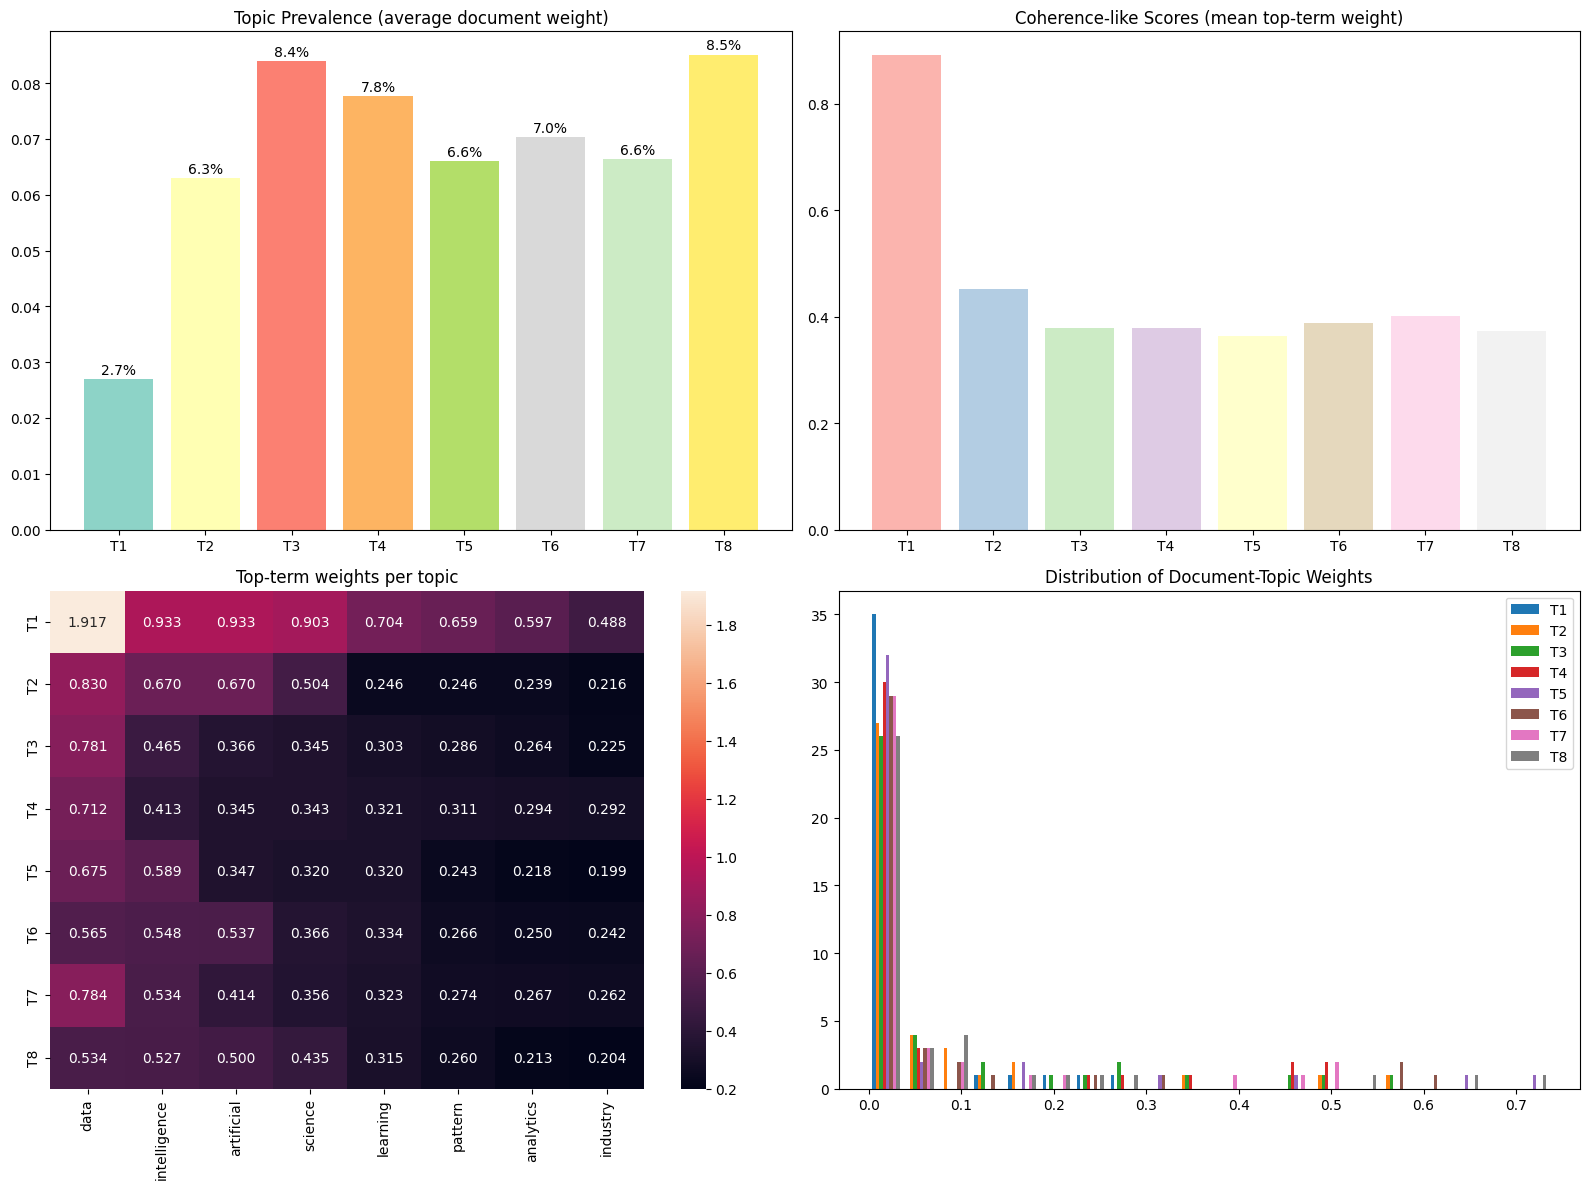

In [ ]:
# Summary visualisation (prevalence, coherence, heatmap)
def create_summary_visualisations(topic_terms, doc_topic_dist, topic_names):
    n_topics = len(topic_terms)
    topic_prev = np.mean(doc_topic_dist, axis=0)
    coherence_scores = [np.mean([w for _, w in topic_terms[t][:10]]) for t in range(n_topics)]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    # Prevalence bar chart
    axes[0,0].bar(range(n_topics), topic_prev, color=plt.cm.Set3(np.linspace(0,1,n_topics)))
    axes[0,0].set_title("Topic Prevalence (average document weight)")
    axes[0,0].set_xticks(range(n_topics))
    axes[0,0].set_xticklabels([f"T{i+1}" for i in range(n_topics)])
    for i, v in enumerate(topic_prev):
        axes[0,0].text(i, v + 0.001, f"{v:.1%}", ha='center')

    # Coherence-like scores
    axes[0,1].bar(range(n_topics), coherence_scores, color=plt.cm.Pastel1(np.linspace(0,1,n_topics)))
    axes[0,1].set_title("Coherence-like Scores (mean top-term weight)")
    axes[0,1].set_xticks(range(n_topics))
    axes[0,1].set_xticklabels([f"T{i+1}" for i in range(n_topics)])

    # Heatmap of top-term weights
    top_k = 8
    heat = np.zeros((n_topics, top_k))
    labels = []
    for t in range(n_topics):
        tw = topic_terms[t][:top_k]
        if t == 0:
            labels = [w for w, _ in tw]
        for k, (_, w) in enumerate(tw):
            heat[t, k] = w
    sns.heatmap(heat, annot=True, fmt=".3f", ax=axes[1,0], xticklabels=labels, yticklabels=[f"T{i+1}" for i in range(n_topics)])
    axes[1,0].set_title("Top-term weights per topic")

    # Document-topic distribution histograms
    axes[1,1].hist([doc_topic_dist[:, i] for i in range(n_topics)], bins=20, stacked=False, label=[f"T{i+1}" for i in range(n_topics)])
    axes[1,1].legend()
    axes[1,1].set_title("Distribution of Document-Topic Weights")

    plt.tight_layout()
    plt.show()

create_summary_visualisations(topic_terms, doc_topic_distributions, topic_names)


### Conclusion

This notebook successfully implemented Non-negative Matrix Factorisation (NMF) on a sample corpus, moving from raw text through essential preprocessing and vectorization. We extracted three distinct latent topics: Finance, Sports, and Technology.

The interpretation phase demonstrated two effective methods for communicating these results:

1. Word Clouds offered an immediate, intuitive summary of the top words.

2. pyLDAvis provided a rigorous, interactive tool to confirm topic coherence, visualize the distance between themes, and analyze the specific words that make each topic unique.

Topic modelling is a powerful tool for large-scale document analysis, enabling rapid understanding of the core themes and structure within massive text datasets.